In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
device

device(type='cuda')

In [3]:
class TorchDataset(Dataset):
    def __init__(self, path):
        self.x, self.y = torch.load(path)
        self.y = F.one_hot(self.y, num_classes=10).to(float)
        
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [4]:
trainset = TorchDataset('MNIST\\processed\\training.pt')
testset = TorchDataset('MNIST\\processed\\test.pt')

In [5]:
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

In [6]:
trainset[:][0].float().mean()

tensor(33.3255)

In [7]:
trainset[0][0].shape, trainset[0][1].shape

(torch.Size([28, 28]), torch.Size([10]))

In [8]:
xs, ys = trainset[:5]
ys.shape

torch.Size([5, 10])

In [9]:
ys[0]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

In [10]:
traindl = DataLoader(trainset, batch_size = 50)
valdl = DataLoader(valset, batch_size = 50)

In [11]:
for x, y in traindl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([50, 28, 28])
torch.Size([50, 10])


In [12]:
len(traindl)

1000

In [13]:
L = nn.CrossEntropyLoss()

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(28**2, 100, bias=False)
        self.bn1 = nn.BatchNorm1d(100)
        self.linear2 = nn.Linear(100, 50, bias=False)
        self.bn2 = nn.BatchNorm1d(50)
        self.linear3 = nn.Linear(50, 10, bias=False)
        self.R = nn.ReLU()
        
        self.history = []
        self.batch_history = []
        self.val_history = []  
        
    def forward(self, x):
        self.linear1ins, self.linear1outs = [], []
        self.linear2outs = []
        
        x = x.to(dtype=torch.float32)
        x = x.to(device)
        x = x.view(-1, 28**2)
        self.linear1ins.append(x)
        x = self.linear1(x)
        x = self.R(self.bn1(x))
        self.linear1outs.append(x)
        x = self.linear2(x)
        x = self.R(self.bn2(x))
        self.linear2outs.append(x)
        x = self.linear3(x)
        
        return x

In [48]:
def train(dl, model, optimizer, n_epochs=10, valdl=None):
    optimizer = optimizer
    L = nn.CrossEntropyLoss()
    for epoch in range(n_epochs):
        batch_loss = []
        val_batch_loss = []
        for x, y in dl:
            y = y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = L(out, y)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
            model.batch_history.append(loss.item())
            
        model.history.append(np.array(batch_loss).mean())
        
        if valdl:
            with torch.no_grad():
                for valx, valy in valdl:
                    valy = valy.to(device)
                    out = model(valx)
                    loss = L(out, valy)
                    val_batch_loss.append(loss.item())
                model.val_history.append(np.array(val_batch_loss).mean())
                print(f'Epoch {len(model.history)}: Loss: {np.array(batch_loss).mean():.4f}, ValLoss: {np.array(val_batch_loss).mean():.4f}')
        else:
            print(f'Epoch {len(model.history)}: TrainAcc: {true/(true+false)}, Loss: {np.array(batch_loss).mean():.4f}')
            
            
def evaluate(dl, model):
    model.eval()
    true, false = 0, 0
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        pred = model(x)    
        if pred.argmax() == y.argmax():
            true += 1
        else:
            false += 1
    accuracy = true/(true+false)
    return accuracy 

In [16]:
mnist_model = Net()
mnist_model = mnist_model.to(device)

In [17]:
optimizer = SGD(mnist_model.parameters(), lr = 0.001)

In [18]:
train(traindl, mnist_model, optimizer, n_epochs=10, valdl=valdl)

Epoch 1: Loss: 1.4896, ValLoss: 1.0662
Epoch 2: Loss: 0.8907, ValLoss: 0.7415
Epoch 3: Loss: 0.6576, ValLoss: 0.5757
Epoch 4: Loss: 0.5298, ValLoss: 0.4786
Epoch 5: Loss: 0.4505, ValLoss: 0.4151
Epoch 6: Loss: 0.3959, ValLoss: 0.3699
Epoch 7: Loss: 0.3555, ValLoss: 0.3357
Epoch 8: Loss: 0.3238, ValLoss: 0.3088
Epoch 9: Loss: 0.2981, ValLoss: 0.2870
Epoch 10: Loss: 0.2766, ValLoss: 0.2688


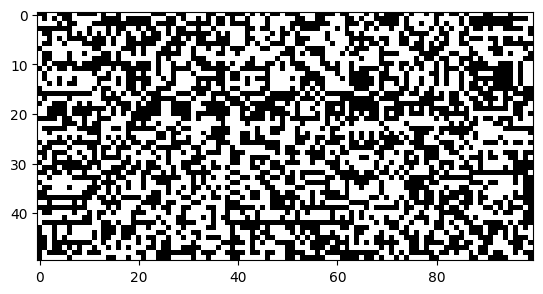

In [19]:
plt.imshow(mnist_model.linear1outs[0].cpu() > 0.0, cmap = 'gray', interpolation='nearest')
plt.show()

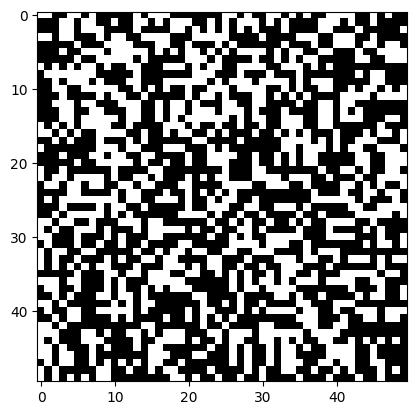

In [20]:
plt.imshow(mnist_model.linear2outs[0].cpu() > 0.0, cmap = 'gray', interpolation='nearest')

In [21]:
mnist_model.linear2outs[0].cpu()

tensor([[0.9413, 1.1027, 0.0000,  ..., 0.3375, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3300],
        ...,
        [0.0000, 0.8745, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.6113, 0.0000, 0.5439,  ..., 0.0000, 0.4087, 0.0000],
        [1.5747, 0.0000, 2.5257,  ..., 0.0000, 0.0000, 0.0000]])

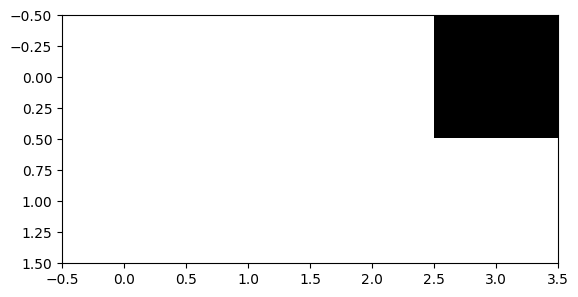

In [22]:
plt.imshow(torch.tensor([[5,5,5,-5],[5,5,5,5]])> 0, cmap='gray')

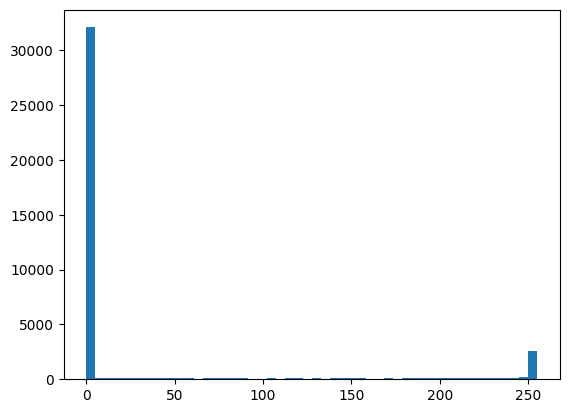

In [23]:
plt.hist(mnist_model.linear1ins[0].cpu().view(-1).tolist(), 50);

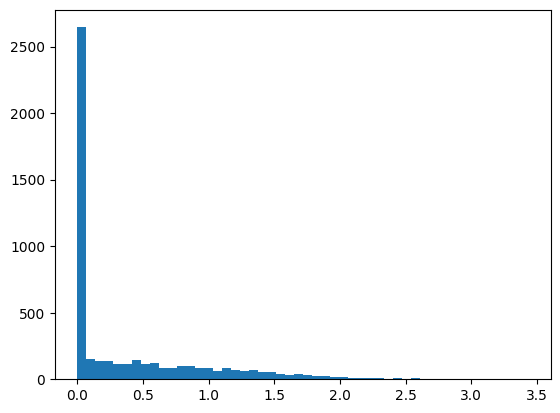

In [24]:
plt.hist(mnist_model.linear1outs[0].cpu().view(-1).tolist(), 50);

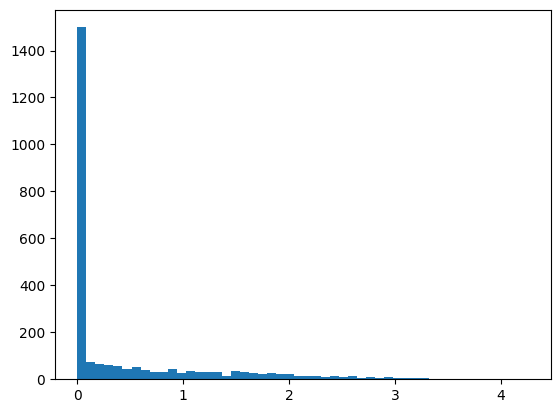

In [25]:
plt.hist(mnist_model.linear2outs[0].cpu().view(-1).tolist(), 50);

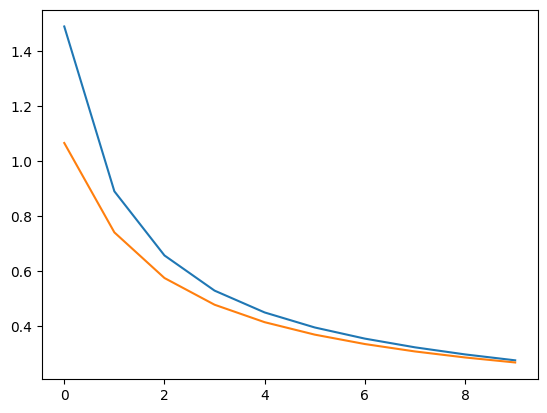

In [26]:
plt.plot(mnist_model.history)
plt.plot(mnist_model.val_history)

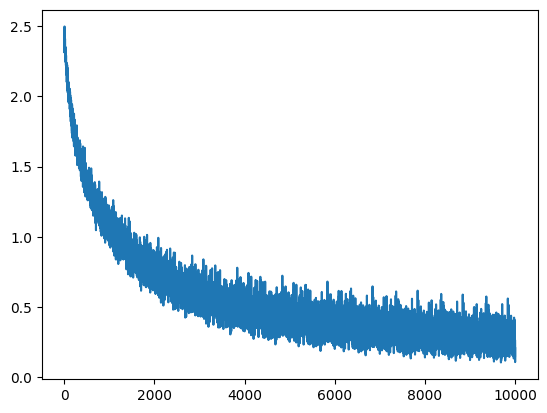

In [27]:
plt.plot(mnist_model.batch_history)

In [28]:
trainset[0][0].shape

torch.Size([28, 28])

In [29]:
xs, ys = testset[:]
yhats = mnist_model(xs).argmax(axis=1)

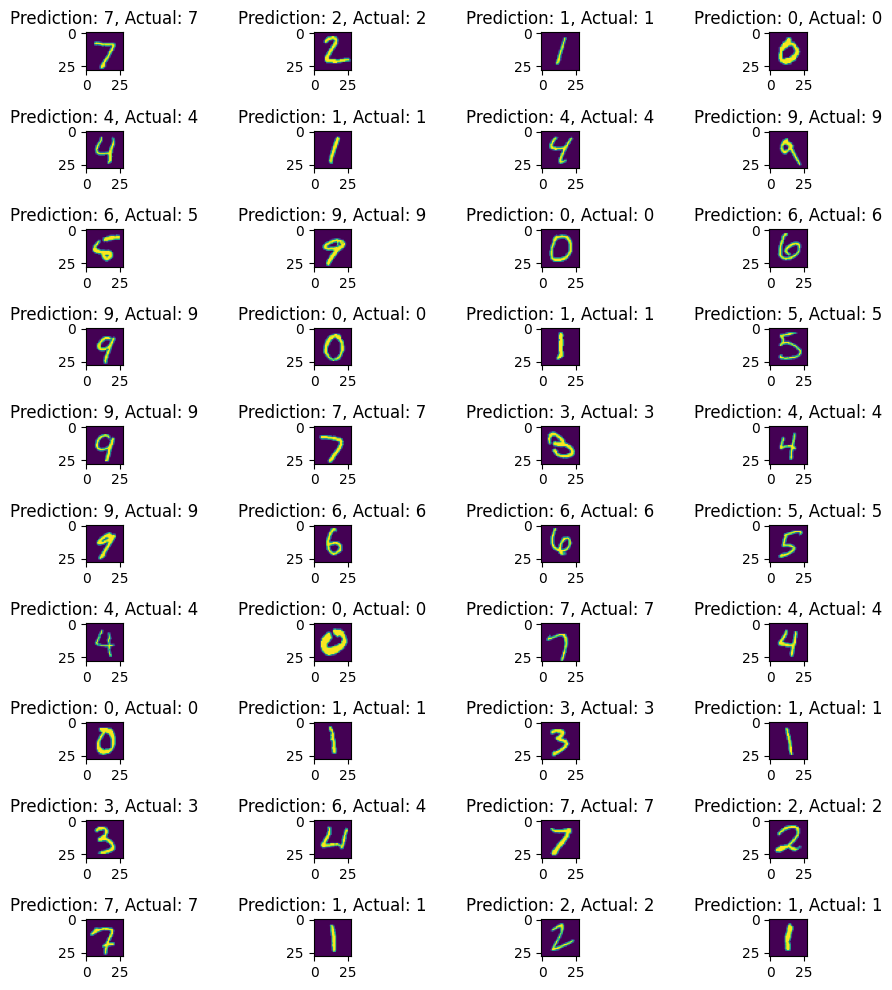

In [30]:
fig, ax = plt.subplots(10,4, figsize=(10,10))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Prediction: {yhats[i]}, Actual: {ys[i].argmax(axis=0).item()}')
fig.tight_layout()
plt.show()

In [49]:
evaluate(testset, mnist_model)

0.9447

In [50]:
evaluate(trainset, mnist_model)

0.94646

In [51]:
evaluate(valset, mnist_model)

0.9444